In [3]:
import pandas as pd
# from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3
%matplotlib inline
# mpld3.enable_notebook()

N_JOBS = 5

In [4]:
datatrain = pd.read_csv('dataset/fraud_train.csv')
datatest = pd.read_csv('dataset/fraud_train.csv')

# Step
1. praprocessing
    1. preparing the preparation
    2. Exploratory Data Analysis
    3. Dealing with Missing Values
    4. Dealing with Outliers
    5. Dealing with Imbalanced Data
    6. Data Transformations
    7. Finishing Touches & Moving Ahead
2. process
    1. Logistic Regression
    2. Decision Tree
    3. Random Forest
    4. Neural Networks
3. summary and conclutions

## Refference
1. praprocessing 
    1. https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
    1. https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python
    1. https://www.kdnuggets.com/2017/06/7-steps-mastering-data-preparation-python.html/2
    1. https://github.com/pandas-profiling/pandas-profiling
    2. https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
    3. https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/
    1. https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/
    1. https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68
    1. https://github.com/ajaymache/data-analysis-using-python
1. process

## 1. Praprocessing

### B. Exploratory Data Analysis

In [ ]:
datatrain.head()

In [ ]:
# datatrain["nama_merchant"].value_counts()
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# ax = sns.countplot(x="nama_merchant", data=datatrain)

# total = len(datatrain)
# for p in ax.patches:
#         ax.annotate('({:.1f}%)'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

In [ ]:
graphout = datatrain[['flag_transaksi_fraud','tipe_kartu','nama_transaksi','nama_channel']]
fig, axes = plt.subplots(round(len(graphout.columns) / 2), 2, figsize=(12, 12))
total = len(graphout)

for i, ax in enumerate(fig.axes):
    if i < len(graphout.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=graphout.columns[i], alpha=0.7, data=graphout, ax=ax)
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

fig.tight_layout()

In [ ]:
# datatrain.corr()

In [ ]:
graphoutscatter = datatrain[['flag_transaksi_fraud','tipe_kartu','nama_transaksi','nama_channel', 'nilai_transaksi']]
# fig, axes = plt.subplots(round(len(graphoutscatter.columns) / 2), 2, figsize=(12, 12))
        
for i in range(0, round(len(graphoutscatter.columns) / 2), 2):
    sns.pairplot(data=graphoutscatter,
                x_vars=graphoutscatter.columns[i:i+5],
                y_vars=['nilai_transaksi'])

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
corr = datatrain.corr(method='pearson')
# corr = datatrain.corr(method='spearman')

ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True, annot_kws={"size": 8}, fmt='.1g')#, cmap='viridis')
ax.set_title('Correlation pearson')

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(datatrain)

### C. Dealing with Missing Values

1. https://clevertap.com/blog/how-to-treat-missing-values-in-your-data-part-i/
1. https://clevertap.com/blog/how-to-treat-missing-values-in-your-data-part-ii/

#### method
1. delete row (with nan val)
1. average nan from global value
1. predict 

#### tools
1. http://pandas.pydata.org/pandas-docs/stable/missing_data.html
1. http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values
1. KNN https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
1. KNN sklearn https://github.com/scikit-learn/scikit-learn/pull/9212
1. KNN keagle https://www.kaggle.com/dan195/knn-imputation-gbregression-an-plsregression

In [ ]:
datatrain.shape

In [ ]:
datatrain.dropna().shape

In [ ]:
datatrain.isnull().values.any()

In [ ]:
datatrain.isnull().sum()#.sum()

In [ ]:
nan_rows = datatrain[datatrain.isnull().T.any().T]
nan_rows

In [ ]:
datatrain.describe()

In [ ]:
datatrain.info() 

##### a. Handling missing value with drop row

In [ ]:
datatrain1 = datatrain.dropna()

In [ ]:
datatrain1 =  datatrain.fillna(0)
datatrain1[datatrain1.isnull().T.any().T]

In [ ]:
# datatrain.count()

In [ ]:
# datatrain.interpolate().count()

##### b. Handling missing value with KNN

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [ ]:
hasil = knn_impute(target=datatrain['maksimum_nilai_transaksi'], attributes=datatrain.drop(['rata_rata_nilai_transaksi','minimum_nilai_transaksi','rata_rata_jumlah_transaksi'],1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.9)

In [ ]:
hasil1 = hasil.as_matrix()
hasil1[3752]

In [ ]:
datatrain['maksimum_nilai_transaksi'] = hasil

In [ ]:
# hasil1 = datatrain.as_matrix()
# hasil1[3752]
datatrain[3752:3753]
# array([12287602.94406288])

### D. Dealing with Outliers

1. https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html
1. https://medium.com/@dhwajraj/learning-python-regression-analysis-part-7-handling-outliers-in-data-d36ee9e2130b
1. https://www.kaggle.com/general/24617

In [6]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = list(zip(x, func(x)))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['debt', 'outlier'])
    if replace == 'median':
        replace = x.debt.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace)
        else:
            debtNew.append(x.iloc[i][0])
    
    return debtNew

In [ ]:
datatrain.head()

In [ ]:
datatrain.shape

In [ ]:
graphoutbox = datatrain[['nilai_transaksi','rata_rata_nilai_transaksi','maksimum_nilai_transaksi','minimum_nilai_transaksi', 'rata_rata_jumlah_transaksi']]
fig, axes = plt.subplots(round(len(graphoutbox.columns) / 2), 2, figsize=(12, 12))

for i, ax in enumerate(fig.axes):
    if i < len(graphoutbox.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=graphoutbox.columns[i],data=graphoutbox, ax=ax)

fig.tight_layout()

In [ ]:
import pprint
print("nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.nilai_transaksi))
print("")
print("rata_rata_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.rata_rata_nilai_transaksi))
print("")
print("maksimum_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.maksimum_nilai_transaksi))
print("")
print("minimum_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.minimum_nilai_transaksi))
print("")
print("rata_rata_jumlah_transaksi : ")
pprint.pprint(outlierRatio(datatrain.rata_rata_jumlah_transaksi))

In [ ]:
# datatrain.rata_rata_jumlah_transaksi.plot.box()
# ax = sns.boxplot(y=datatrain["rata_rata_jumlah_transaksi"])
plotOutlier(datatrain.rata_rata_jumlah_transaksi)
plotOutlierFree(datatrain.rata_rata_jumlah_transaksi)

In [ ]:
# df = pd.DataFrame({'Data':np.random.normal(size=200)})
# # example dataset of normally distributed data. 

# df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]
# # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

# df[~(np.abs(df.Data-df.Data.mean()) > (3*df.Data.std()))]
# # or if you prefer the other way around

# ================================================================================================================

# fig, ax = plt.subplots(figsize=(16,8))
# ax.scatter(datatrain['id_tanggal_transaksi_awal'], datatrain['rata_rata_nilai_transaksi'])
# # ax.set_xlabel('Proportion of non-retail business acres per town')
# # ax.set_ylabel('Full-value property-tax rate per $10,000')
# plt.show()

# ================================================================================================================

# # a number "a" from the vector "x" is an outlier if 
# # a > median(x)+1.5*iqr(x) or a < median-1.5*iqr(x)
# # iqr: interquantile range = third interquantile - first interquantile
# def outliers(x): 
#        return np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))

# # Give the outliers for the first column for example
# datatrain.nilai_transaksi[outliers(datatrain.nilai_transaksi)]

# # Replace the upper outlier(s) with the 95th percentile and the lower one(s) with the 5th percentile 
# def replace(x):   # x is a vector
#        out = x[outliers(x)]
#        return x.replace(to_replace = [out.min(),out.max()], 
#                         value = [np.percentile(x,5),np.percentile(x,95)])

# # Apply replace() on each column of the dataframe
# datatrain.apply(replace,axis=1)

# datatrain[~datatrain.apply(outliers).any(axis=1)]

In [ ]:
newRatJumTrans = replaceOutlier(datatrain.rata_rata_jumlah_transaksi, replace='median')#'minUpper')
# newRatJumTrans

In [ ]:
datatrain.head()

In [7]:
def removeOutliers(data, item):
    itemdata = data[item]
    asd = data[np.abs(itemdata-itemdata.mean()) <= (3*itemdata.std())]
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    itemdata = asd[item]
    asd = asd[~(np.abs(itemdata-itemdata.mean()) > (3*itemdata.std()))]
    # or if you prefer the other way around
    return asd

newdatatrain = removeOutliers(datatrain, 'rata_rata_jumlah_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'rata_rata_nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'maksimum_nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'minimum_nilai_transaksi')
print(newdatatrain.shape)
print(datatrain.shape)

(12594, 28)
(12042, 28)
(11631, 28)
(11075, 28)
(10622, 28)
(13125, 28)


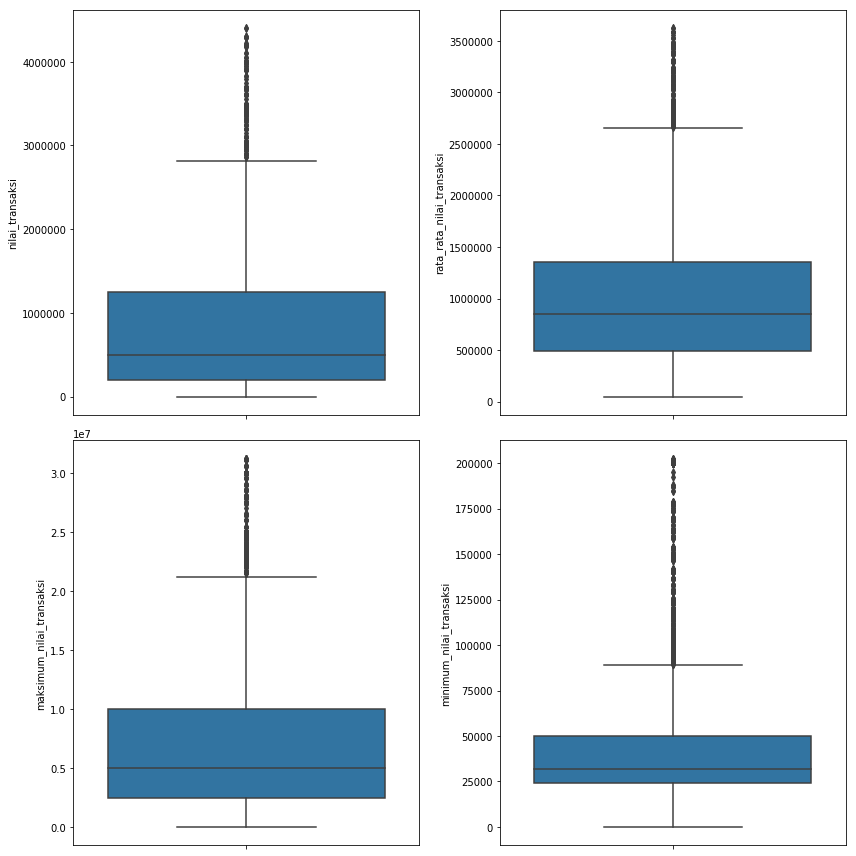

In [8]:
graphoutbox = newdatatrain[['nilai_transaksi','rata_rata_nilai_transaksi','maksimum_nilai_transaksi','minimum_nilai_transaksi', 'rata_rata_jumlah_transaksi']]
fig, axes = plt.subplots(round(len(graphoutbox.columns) / 2), 2, figsize=(12, 12))

for i, ax in enumerate(fig.axes):
    if i < len(graphoutbox.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=graphoutbox.columns[i],data=graphoutbox, ax=ax)

fig.tight_layout()

### E. Dealing with Imbalanced Data


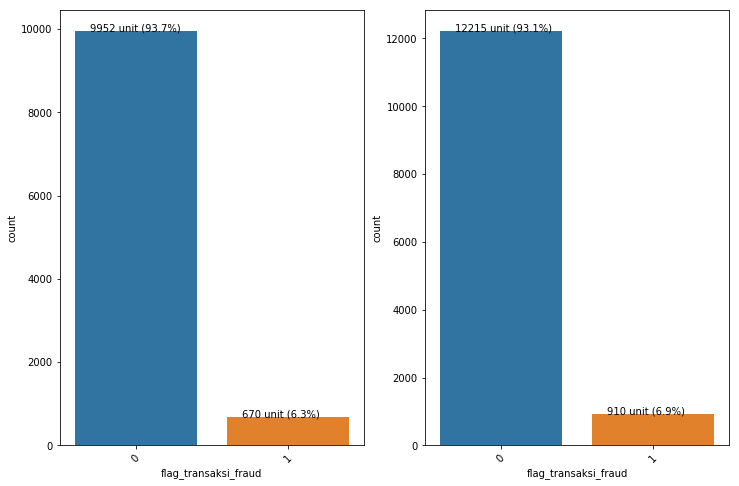

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=newdatatrain, ax=ax)
total = len(newdatatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")

ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

In [10]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = newdatatrain[newdatatrain.flag_transaksi_fraud==0]
df_minority = newdatatrain[newdatatrain.flag_transaksi_fraud==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=9952,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.flag_transaksi_fraud.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    9952
0    9952
Name: flag_transaksi_fraud, dtype: int64

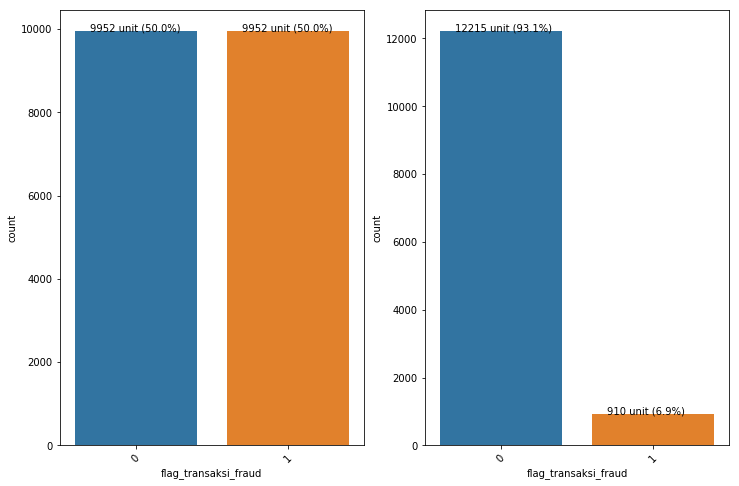

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_upsampled, ax=ax)
total = len(df_upsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")

ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

In [12]:
# Separate majority and minority classes
df_majority = newdatatrain[newdatatrain.flag_transaksi_fraud==0]
df_minority = newdatatrain[newdatatrain.flag_transaksi_fraud==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=670,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.flag_transaksi_fraud.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

1    670
0    670
Name: flag_transaksi_fraud, dtype: int64

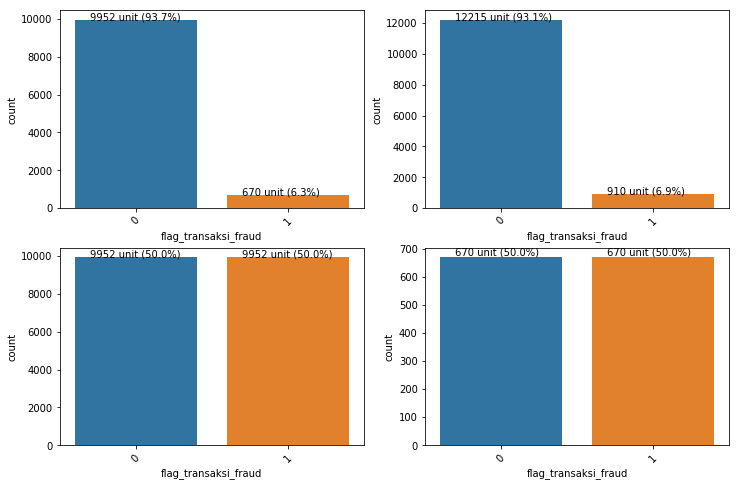

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=newdatatrain, ax=ax)
total = len(newdatatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")


ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")


ax = fig.axes[2]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_upsampled, ax=ax)
total = len(df_upsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")


ax = fig.axes[3]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_downsampled, ax=ax)
total = len(df_downsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [21]:
# Separate input features (X) and target variable (y)
y = df_downsampled.flag_transaksi_fraud
X = df_downsampled.drop('flag_transaksi_fraud', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )
# 0.581632653061

[0 1]
0.6888059701492537


In [22]:
# Separate input features (X) and target variable (y)
y = df_upsampled.flag_transaksi_fraud
X = df_upsampled.drop('flag_transaksi_fraud', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )
# 0.581632653061

[0 1]
0.6864449356913184


In [31]:
# Separate input features (X) and target variable (y)
y = newdatatrain.flag_transaksi_fraud
X = newdatatrain.drop('flag_transaksi_fraud', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )
# 0.581632653061

[0 1]
0.93673507813971


In [27]:
# Separate input features (X) and target variable (y)
nd = datatrain.dropna()
y = nd.flag_transaksi_fraud
X = nd.drop('flag_transaksi_fraud', axis=1)
 
# Train model
clf_2 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_2 = clf_2.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y, pred_y_2) )
# 0.581632653061

[0 1]
0.9320054945054945


In [32]:
datatest = datatest.dropna()
y_test = datatest.flag_transaksi_fraud
X_test = datatest.drop('flag_transaksi_fraud', axis=1)

# Predict on training set
pred_y_2 = clf_2.predict(X_test)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y_test, pred_y_2) )
# 0.581632653061

[0 1]
0.9108669108669109


In [34]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X, y, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.937


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred_y_2)
print(confusion_matrix)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf_2.score(X_test, y_test)))

[[11826   384]
 [  784   110]]
Accuracy of logistic regression classifier on test set: 0.91


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y_2))

             precision    recall  f1-score   support

          0       0.94      0.97      0.95     12210
          1       0.22      0.12      0.16       894

avg / total       0.89      0.91      0.90     13104



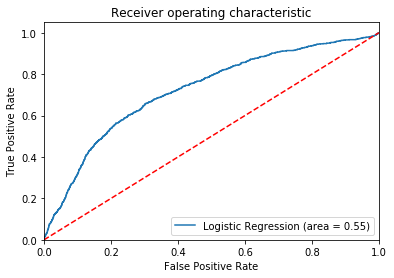

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf_2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf_2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()